In [1]:
# --- Supabase Data Collection and Preparation Notebook ---
# This notebook demonstrates how to connect to Supabase, fetch audio metadata, clean the data, and prepare it for audio analysis and machine learning.
# It is intended as a template for your data preparation workflow.

# Step 1: Import required libraries and load environment variables
# Make sure you have a .env file with SUPABASE_URL and SUPABASE_KEY set.
import os
from dotenv import load_dotenv
import pandas as pd
from supabase import create_client, Client

# Load environment variables
load_dotenv()

# Get Supabase credentials from environment variables
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

if not url or not key:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in your .env file")

# Initialize the Supabase client
supabase: Client = create_client(url, key)

# Step 2: Query the audio_files table from Supabase
# This pulls all metadata for the audio files into a pandas DataFrame.
res = supabase.table("audio_files").select(
    "id,bucket_id,object_name,content_type,size_bytes,created_at,top_level_folder,second_level_folder,species"
).execute()

# Convert to DataFrame
df = pd.DataFrame(res.data)
print(df.head())

                                     id   bucket_id  \
0  a1d8e5cc-6391-4b91-97ef-b3270e59f3a5  frog-audio   
1  783e5c27-3c18-4098-a0c5-589cfeddeac0  frog-audio   
2  7d62c4c7-1fc3-4bc8-8175-240caa56703c  frog-audio   
3  2139be56-caaf-4bf6-8c2e-9c72e887575c  frog-audio   
4  f8bae573-c7e5-4ea1-b57f-0b5e168d8c80  frog-audio   

                                         object_name content_type  size_bytes  \
0  digital_library_of_georgia/atlmetro_14_species...   audio/mpeg     1333019   
1  xenocanto/atlmetro_14_species/pickerel_frog/XC...    audio/wav    31773690   
2  macaulay_library/atlmetro_14_species/green_tre...   audio/mpeg      609024   
3  usgs/atlmetro_14_species/spring_peeper/295182.mp3   audio/mpeg      214913   
4  xenocanto/atlmetro_14_species/green_tree_frog/...    audio/wav     1589930   

                         created_at            top_level_folder  \
0   2025-10-20T02:56:33.75325+00:00  digital_library_of_georgia   
1  2025-10-20T21:56:07.847004+00:00             

In [2]:
# Step 3: Quick inspection of object names
# This helps you understand the folder structure and naming conventions for your audio files.
for obj_name in df['object_name']:
    print(obj_name)

digital_library_of_georgia/atlmetro_14_species/green_frog/dlg_ggpd_n200-g2-m1-2013-c3-track-88.mp3
xenocanto/atlmetro_14_species/pickerel_frog/XC895182 - Pickerel Frog - Lithobates palustris.wav
macaulay_library/atlmetro_14_species/green_tree_frog/frog_human/ML183665.mp3
usgs/atlmetro_14_species/spring_peeper/295182.mp3
xenocanto/atlmetro_14_species/green_tree_frog/XC883689 - North American Green Treefrog - Dryophytes cinereus.wav
xenocanto/atlmetro_14_species/spring_peeper/XC796213 - Spring Peeper - Pseudacris crucifer.mp3
macaulay_library/atlmetro_14_species/american_toad/ML182054.mp3
xenocanto/atlmetro_14_species/spring_peeper/XC1020609 - Spring Peeper - Pseudacris crucifer.wav
macaulay_library/atlmetro_14_species/copes_gray_treefrog/ML222925.mp3
macaulay_library/atlmetro_14_species/bird_voiced_tree_frog/frog_human/ML181942.mp3
macaulay_library/atlmetro_14_species/american_toad/ML635754925.mp3
macaulay_library/atlmetro_14_species/american_toad/ML179129.mp3
macaulay_library/atlmetro_

In [3]:
# Step 4: Data Cleaning - Remove unwanted audio instances
# For model training, we want to exclude audio files that contain human speech.
# These are labeled in the 'frog_human' folder, and only occur in the 'macaulay_library' top-level folder.
# This step drops all such instances from the DataFrame.
mask = ~((df['object_name'].str.contains('frog_human')) & (df['top_level_folder'] == 'macaulay_library'))
df_clean = df[mask].reset_index(drop=True)
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print(df_clean.head())

Original shape: (1887, 9)
Cleaned shape: (1400, 9)
                                     id   bucket_id  \
0  a1d8e5cc-6391-4b91-97ef-b3270e59f3a5  frog-audio   
1  783e5c27-3c18-4098-a0c5-589cfeddeac0  frog-audio   
2  2139be56-caaf-4bf6-8c2e-9c72e887575c  frog-audio   
3  f8bae573-c7e5-4ea1-b57f-0b5e168d8c80  frog-audio   
4  94f14dd4-c1e2-4a86-83d0-84e664143ba0  frog-audio   

                                         object_name content_type  size_bytes  \
0  digital_library_of_georgia/atlmetro_14_species...   audio/mpeg     1333019   
1  xenocanto/atlmetro_14_species/pickerel_frog/XC...    audio/wav    31773690   
2  usgs/atlmetro_14_species/spring_peeper/295182.mp3   audio/mpeg      214913   
3  xenocanto/atlmetro_14_species/green_tree_frog/...    audio/wav     1589930   
4  xenocanto/atlmetro_14_species/spring_peeper/XC...   audio/mpeg      372755   

                         created_at            top_level_folder  \
0   2025-10-20T02:56:33.75325+00:00  digital_library_of_georgia 

In [4]:
# Step 5: Basic EDA (Exploratory Data Analysis)
# This gives an overview of the cleaned DataFrame and helps spot issues before further processing.
print('Shape:', df_clean.shape)
print('Columns:', df_clean.columns.tolist())
print('Missing values per column:')
print(df_clean.isnull().sum())
print('Data types:')
print(df_clean.dtypes)
print('Summary statistics:')
print(df_clean.describe(include='all'))

Shape: (1400, 9)
Columns: ['id', 'bucket_id', 'object_name', 'content_type', 'size_bytes', 'created_at', 'top_level_folder', 'second_level_folder', 'species']
Missing values per column:
id                     0
bucket_id              0
object_name            0
content_type           0
size_bytes             0
created_at             0
top_level_folder       0
second_level_folder    0
species                0
dtype: int64
Data types:
id                     object
bucket_id              object
object_name            object
content_type           object
size_bytes              int64
created_at             object
top_level_folder       object
second_level_folder    object
species                object
dtype: object
Summary statistics:
                                          id   bucket_id  \
count                                   1400        1400   
unique                                  1400           1   
top     a1d8e5cc-6391-4b91-97ef-b3270e59f3a5  frog-audio   
freq                

In [5]:
# Step 6: Breakdown of instances per species
# This helps you understand class balance and identify rare species.
species_counts = df_clean['species'].value_counts()
print("Species counts:")
print(species_counts)

Species counts:
species
american_toad                  183
green_tree_frog                180
northern_cricket_frog          164
copes_gray_treefrog            137
american_bullfrog              123
not_frogs                      117
spring_peeper                  106
eastern_narrow_mouthed_toad     97
green_frog                      84
pickerel_frog                   57
fowlers_toad                    40
southern_leopard_frog           36
upland_chorus_frog              32
bird_voiced_tree_frog           27
eastern_spadefoot_toad          17
Name: count, dtype: int64


In [6]:
# Step 7: Install librosa for audio analysis
# This library is used for feature extraction and visualization of audio files.
%pip install librosa


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Exploratory Data Analysis (EDA) of Frog Audio Files
Let's explore the dataset to understand its structure and key statistics.

Analyzing: digital_library_of_georgia/atlmetro_14_species/green_frog/dlg_ggpd_n200-g2-m1-2013-c3-track-88.mp3
Sample rate: 44100
Duration (seconds): 33.23
Sample rate: 44100
Duration (seconds): 33.23


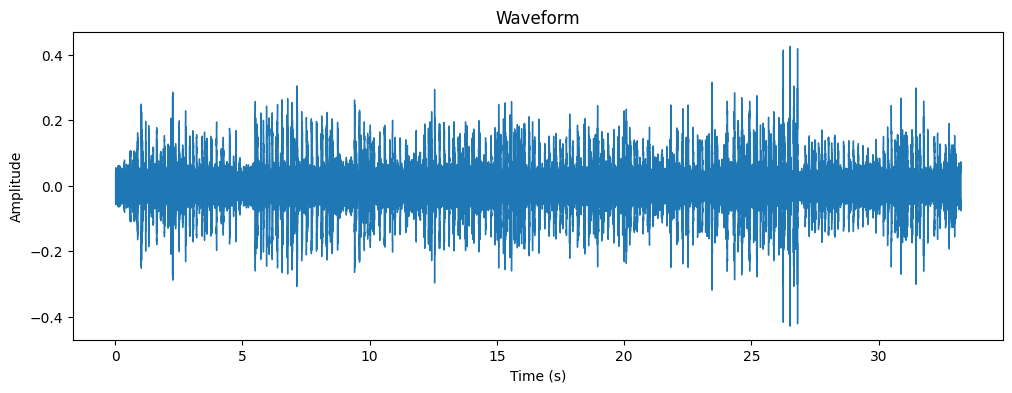

/var/folders/_8/xdjlqs6x4531r8qcsc4wzfb40000gn/T/ipykernel_8679/1834760979.py:57: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


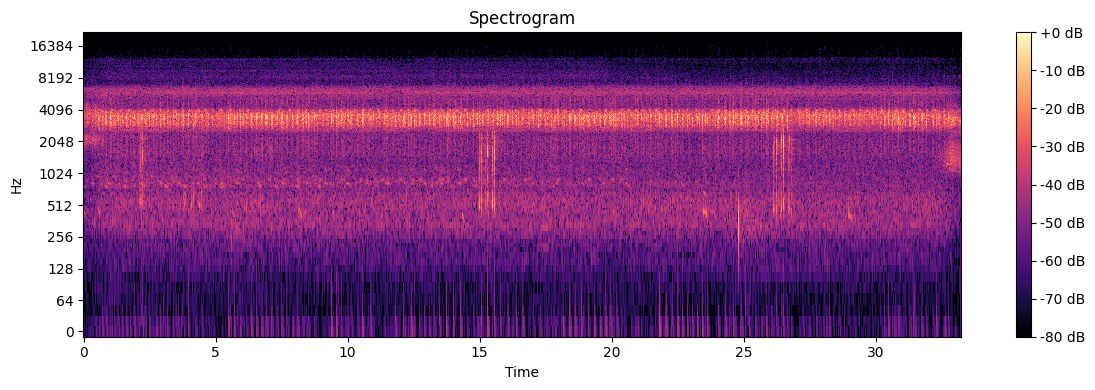

In [7]:
# Step 8: Download and analyze a sample audio file
# This demonstrates how to fetch an audio file from Supabase, load it, and visualize its properties.
import librosa
import librosa.display
import matplotlib.pyplot as plt
import io
import requests
import tempfile
import os
from IPython.display import Audio
import numpy as np

# Select the first audio file from the cleaned DataFrame
sample_row = df_clean.iloc[0]
bucket_id = sample_row['bucket_id']
object_name = sample_row['object_name']
print('Analyzing:', object_name)

# Download the audio file from Supabase storage
def download_audio(supabase, bucket_id, object_name):
    public_url_response = supabase.storage.from_(bucket_id).get_public_url(object_name)
    # Handle both dict and string return types
    if isinstance(public_url_response, dict):
        public_url = public_url_response.get('publicUrl')
    else:
        public_url = public_url_response
    if not public_url:
        raise Exception('Could not get public URL for file')
    response = requests.get(public_url)
    response.raise_for_status()
    return response.content

audio_bytes = download_audio(supabase, bucket_id, object_name)

# Save to a temporary file
with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as tmp_file:
    tmp_file.write(audio_bytes)
    tmp_path = tmp_file.name

# Load audio with librosa
y, sr = librosa.load(tmp_path, sr=None)
print(f'Sample rate: {sr}')
print(f'Duration (seconds): {librosa.get_duration(y=y, sr=sr):.2f}')

# Display audio player
Audio(tmp_path)

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Clean up temporary file
os.remove(tmp_path)